In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from egg.core.interaction import Interaction
from egg.core.language_analysis import calc_entropy, TopographicSimilarity

In [2]:
import os
os.chdir("..")
print("CWD is now:", os.getcwd()) 

CWD is now: /Users/nabilasiregar/code/emergent-communication


In [3]:
from pathlib import Path

candidates = list(Path("logs/msgs").rglob("interaction*"))
print("Found interaction files:")
for p in candidates:
    print(" →", p)

Found interaction files:
 → logs/msgs/interactions
 → logs/msgs/interactions/validation/epoch_10/interaction_masked_human_data:20nodes
 → logs/msgs/interactions/validation/epoch_10/interaction_run1_human_data:20nodes
 → logs/msgs/interactions/validation/epoch_10/interaction_run1_bee_data:20nodes
 → logs/msgs/interactions/validation/epoch_10/interaction_masked_bee_data:20nodes


In [4]:
def load_sequences(interaction_path):
    interaction: Interaction = torch.load(interaction_path)
    msgs    = interaction.message.cpu().numpy()
    lengths = interaction.message_length.cpu().numpy().astype(int)
    
    sequences = [ list(msgs[i, :lengths[i]]) for i in range(len(lengths)) ]
    return sequences, lengths, interaction

In [21]:
bee_path   = "logs/msgs/interactions/validation/epoch_10/interaction_run1_bee_data:20nodes"
hum_path   = "logs/msgs/interactions/validation/epoch_10/interaction_run1_human_data:20nodes"

In [22]:
bee_seq,  bee_len,  bee_int  = load_sequences(bee_path)
hum_seq,  hum_len,  hum_int  = load_sequences(hum_path)

## Corpus stats

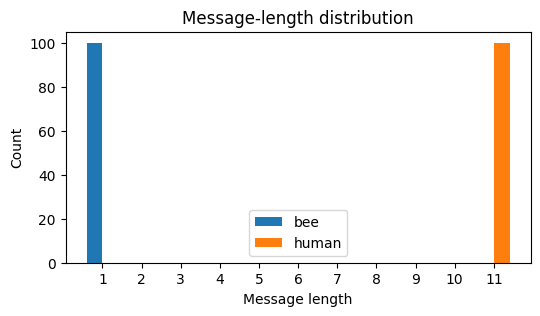

In [34]:
min_len = min(bee_len.min(), hum_len.min())
max_len = max(bee_len.max(), hum_len.max())

bins = np.arange(min_len - 0.5, max_len + 1.5, 1.0)

plt.figure(figsize=(6,3))
plt.hist([bee_len, hum_len],
         bins=bins,
         label=["bee","human"],
         rwidth=0.8)
tick_positions = np.arange(min_len, max_len + 1)
plt.xticks(tick_positions)
plt.xlabel("Message length")
plt.ylabel("Count")
plt.title("Message‐length distribution")
plt.legend()
plt.show()


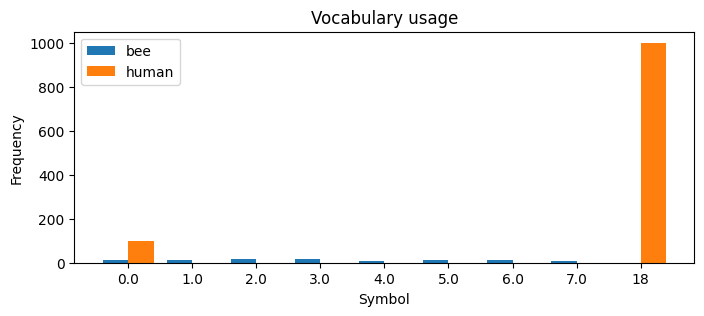

In [24]:
bee_counts = Counter(tok for seq in bee_seq for tok in seq)
hum_counts = Counter(tok for seq in hum_seq for tok in seq)
tokens     = sorted(set(bee_counts) | set(hum_counts))

x = np.arange(len(tokens))
w = 0.4

plt.figure(figsize=(8,3))
plt.bar(x - w/2, [bee_counts[t] for t in tokens], width=w, label="bee")
plt.bar(x + w/2, [hum_counts[t] for t in tokens], width=w, label="human")
plt.xticks(x, tokens)
plt.xlabel("Symbol"); plt.ylabel("Frequency")
plt.legend(); plt.title("Vocabulary usage")
plt.show()

It seems the human protocol has collapsed to a single all‑purpose symbol, while the bee protocol uses the 8 categorical channel as intended

In [29]:
bee_unique = len({ " ".join(map(str,s)) for s in bee_seq })
hum_unique = len({ " ".join(map(str,s)) for s in hum_seq })
print(f"Bee:  {bee_unique}/{len(bee_seq)} unique msg, entropy={calc_entropy(torch.tensor(bee_seq)):.3f}")
print(f"Human:{hum_unique}/{len(hum_seq)} unique msg, entropy={calc_entropy(torch.tensor(hum_seq)):.3f}")


Bee:  8/100 unique msg, entropy=2.933
Human:1/100 unique msg, entropy=-0.000


In [31]:
def compute_topsim(interaction, sequences):
    nest = interaction.aux_input['nest_tensor'].cpu().numpy()
    food = interaction.aux_input['food_tensor'].cpu().numpy()
    meanings = np.stack([nest, food], axis=1)
    topsim = TopographicSimilarity.compute_topsim(
        meanings=torch.tensor(meanings),
        messages=torch.tensor(sequences),
        meaning_distance_fn="euclidean",
        message_distance_fn="edit"
    )
    return topsim

print("Topsim Bee:", compute_topsim(bee_int, bee_seq))
print("Topsim Human:", compute_topsim(hum_int, hum_seq))


Topsim Bee: -0.019587265956028017
Topsim Human: nan


negative topsim with perfect accuracy hints at a lookup‐table rather than solving a task

Bee language is informative but not compositional:
- it uses 8 symbols, one per direction.
- TopSim is negative which means the mapping from (nest, food) pairs to symbols is arbitrary, not geometrically orderly (two pairs that look almost the same spatially can still be mapped to very different messages)

Human:
- Sender always outputs the same token 10 times, which could indicate receiver has learned to ignore the message and rely on visual features only, or there’s a leakage in the architecture.
- Entropy ≈ 0, TopSim undefined: no linguistic content at all

# Masked Node Embeddings for Node Type from Receivers

In [5]:
bee_path   = "logs/msgs/interactions/validation/epoch_10/interaction_masked_bee_data:20nodes"
hum_path   = "logs/msgs/interactions/validation/epoch_10/interaction_masked_human_data:20nodes"

In [6]:
bee_seq,  bee_len,  bee_int  = load_sequences(bee_path)
hum_seq,  hum_len,  hum_int  = load_sequences(hum_path)

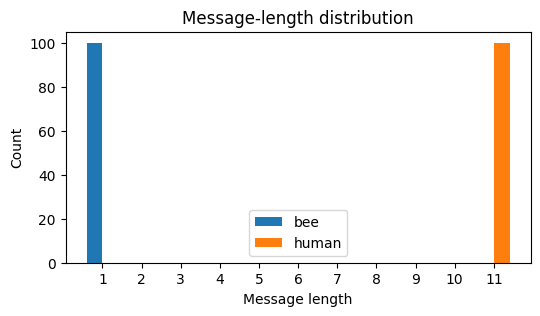

In [7]:
min_len = min(bee_len.min(), hum_len.min())
max_len = max(bee_len.max(), hum_len.max())

bins = np.arange(min_len - 0.5, max_len + 1.5, 1.0)

plt.figure(figsize=(6,3))
plt.hist([bee_len, hum_len],
         bins=bins,
         label=["bee","human"],
         rwidth=0.8)
tick_positions = np.arange(min_len, max_len + 1)
plt.xticks(tick_positions)
plt.xlabel("Message length")
plt.ylabel("Count")
plt.title("Message‐length distribution")
plt.legend()
plt.show()

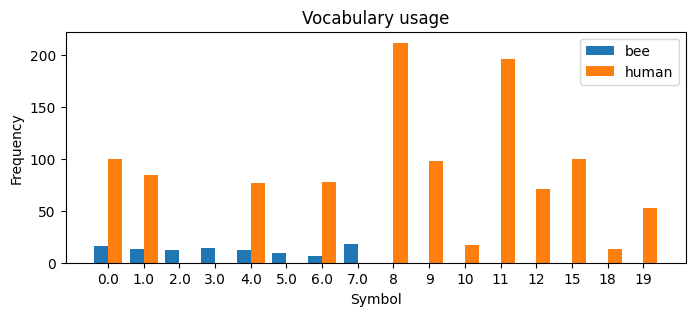

In [8]:
bee_counts = Counter(tok for seq in bee_seq for tok in seq)
hum_counts = Counter(tok for seq in hum_seq for tok in seq)
tokens     = sorted(set(bee_counts) | set(hum_counts))

x = np.arange(len(tokens))
w = 0.4

plt.figure(figsize=(8,3))
plt.bar(x - w/2, [bee_counts[t] for t in tokens], width=w, label="bee")
plt.bar(x + w/2, [hum_counts[t] for t in tokens], width=w, label="human")
plt.xticks(x, tokens)
plt.xlabel("Symbol"); plt.ylabel("Frequency")
plt.legend(); plt.title("Vocabulary usage")
plt.show()

In [9]:
bee_unique = len({ " ".join(map(str,s)) for s in bee_seq })
hum_unique = len({ " ".join(map(str,s)) for s in hum_seq })
print(f"Bee:  {bee_unique}/{len(bee_seq)} unique msg, entropy={calc_entropy(torch.tensor(bee_seq)):.3f}")
print(f"Human:{hum_unique}/{len(hum_seq)} unique msg, entropy={calc_entropy(torch.tensor(hum_seq)):.3f}")

Bee:  8/100 unique msg, entropy=2.938
Human:11/100 unique msg, entropy=2.806


In [10]:
def compute_topsim(interaction, sequences):
    nest = interaction.aux_input['nest_tensor'].cpu().numpy()
    food = interaction.aux_input['food_tensor'].cpu().numpy()
    meanings = np.stack([nest, food], axis=1)
    topsim = TopographicSimilarity.compute_topsim(
        meanings=torch.tensor(meanings),
        messages=torch.tensor(sequences),
        meaning_distance_fn="euclidean",
        message_distance_fn="edit"
    )
    return topsim

print("Topsim Bee:", compute_topsim(bee_int, bee_seq))
print("Topsim Human:", compute_topsim(hum_int, hum_seq))

Topsim Bee: -0.016662485189946483
Topsim Human: -0.00983629019945597
